In [3]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np
from poliastro.frames import Planes

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris
from poliastro.extra_util import  match_astro_query_num

solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [4]:
#simple apijove vs perijove tisserand 
##we take each moon to be in a circular planar orbit at the its SMA.
##we have some set of v infinities relatives to each moon; each is differianted by an angle relative to the Moons velocity vector


v_inftys=list(range(2,13))*u.km/u.s

start_date= time.Time("2037-06-21 00:01", scale="utc").tdb
end_date= time.Time("2038-09-21 00:01", scale="utc").tdb

epoch=time_range(start=start_date, end=end_date)



moon_colors = {
    "Io": "tab:orange",
    "Europa": "tab:blue",
    "Ganymede": "tab:green",
    "Callisto": "tab:purple",
}


/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



In [5]:
def get_apijove_perijove_2d(position_3d, velocity_3d, mu=Jupiter.k):
    """
    Calculate apijove and perijove from 3D position and velocity vectors analytically.
    Only uses the first two components (x, y), ignoring z.
    
    Parameters:
    -----------
    position_3d : array-like with units
        3D position vector [x, y, z] - only x, y are used
    velocity_3d : array-like with units
        3D velocity vector [vx, vy, vz] - only vx, vy are used
    mu : Quantity
        Gravitational parameter of central body (default Jupiter)
    
    Returns:
    --------
    r_apijove : Quantity
        Apoapsis distance from Jupiter center
    r_perijove : Quantity
        Periapsis distance from Jupiter center
    """
    # Extract 2D components (ignore z)
    position_2d = np.array([position_3d[0].value, position_3d[1].value]) * position_3d[0].unit
    velocity_2d = np.array([velocity_3d[0].value, velocity_3d[1].value]) * velocity_3d[0].unit
    
    # Position and velocity magnitudes
    r = np.linalg.norm(position_2d)
    v = np.linalg.norm(velocity_2d)
    
    # Specific orbital energy: ε = v²/2 - μ/r
    epsilon = (v**2 / 2) - (mu / r)
    
    # Semi-major axis: a = -μ/(2ε)
    a = -mu / (2 * epsilon)
    
    # Specific angular momentum (cross product in 2D)
    # h = r × v, in 2D: h_z = x*vy - y*vx
    h_z = position_2d[0] * velocity_2d[1] - position_2d[1] * velocity_2d[0]
    h = np.abs(h_z)
    
    # Eccentricity: e = sqrt(1 + 2*ε*h²/μ²)
    ecc = np.sqrt(1 + (2 * epsilon * h**2) / mu**2)
    
    # Apoapsis and periapsis
    r_apijove = a * (1 + ecc)
    r_perijove = a * (1 - ecc)
    
    return (r_apijove.to(u.km), r_perijove.to(u.km))

In [6]:
anglestep=5#deg
bodies=[Io, Europa, Ganymede, Callisto]
orb_points=np.zeros((4,len(v_inftys),int(180/anglestep)+1,2))


for i,body in enumerate(bodies):
# body=Europa
    body_ephem=Ephem.from_horizons(match_astro_query_num(body),epochs= epoch, attractor= Jupiter, plane=Planes.EARTH_ECLIPTIC)
    body_orb=Orbit.from_ephem(Jupiter,body_ephem,start_date)
    #R is aligned with X axis while V is aligned with Y
    body_r=np.array([body_orb.a.value,0,0])*u.km
    body_v=np.array([0,np.linalg.norm(body_orb.rv()[1].to(u.km/u.s).value),0])*u.km/u.s
    for j,v_infty in enumerate(v_inftys):
        for angle in range(0,185,anglestep):
            # angle=10
            angle_rad=(angle)*math.pi/180
            exit_v_rel=v_infty*np.array([math.sin(angle_rad),math.cos(angle_rad),0])
            exit_v_abs=exit_v_rel+body_v
            # Check if orbit is prograde (angular momentum positive in z-direction)
            # h_z = r_x * v_y - r_y * v_x
            h_z = body_r[0] * exit_v_abs[1] - body_r[1] * exit_v_abs[0]
            
            # Only calculate orbit if it's prograde (h_z > 0)
            if h_z.value > 0:
                r_a,r_p = get_apijove_perijove_2d(body_r,exit_v_abs)
                orb_points[i][j][int(angle/anglestep)][0]=r_p.value
                orb_points[i][j][int(angle/anglestep)][1]=r_a.value
            else:
                # Mark as invalid (will be filtered out during plotting)
                orb_points[i][j][int(angle/anglestep)][0]=0
                orb_points[i][j][int(angle/anglestep)][1]=0
            
    

            

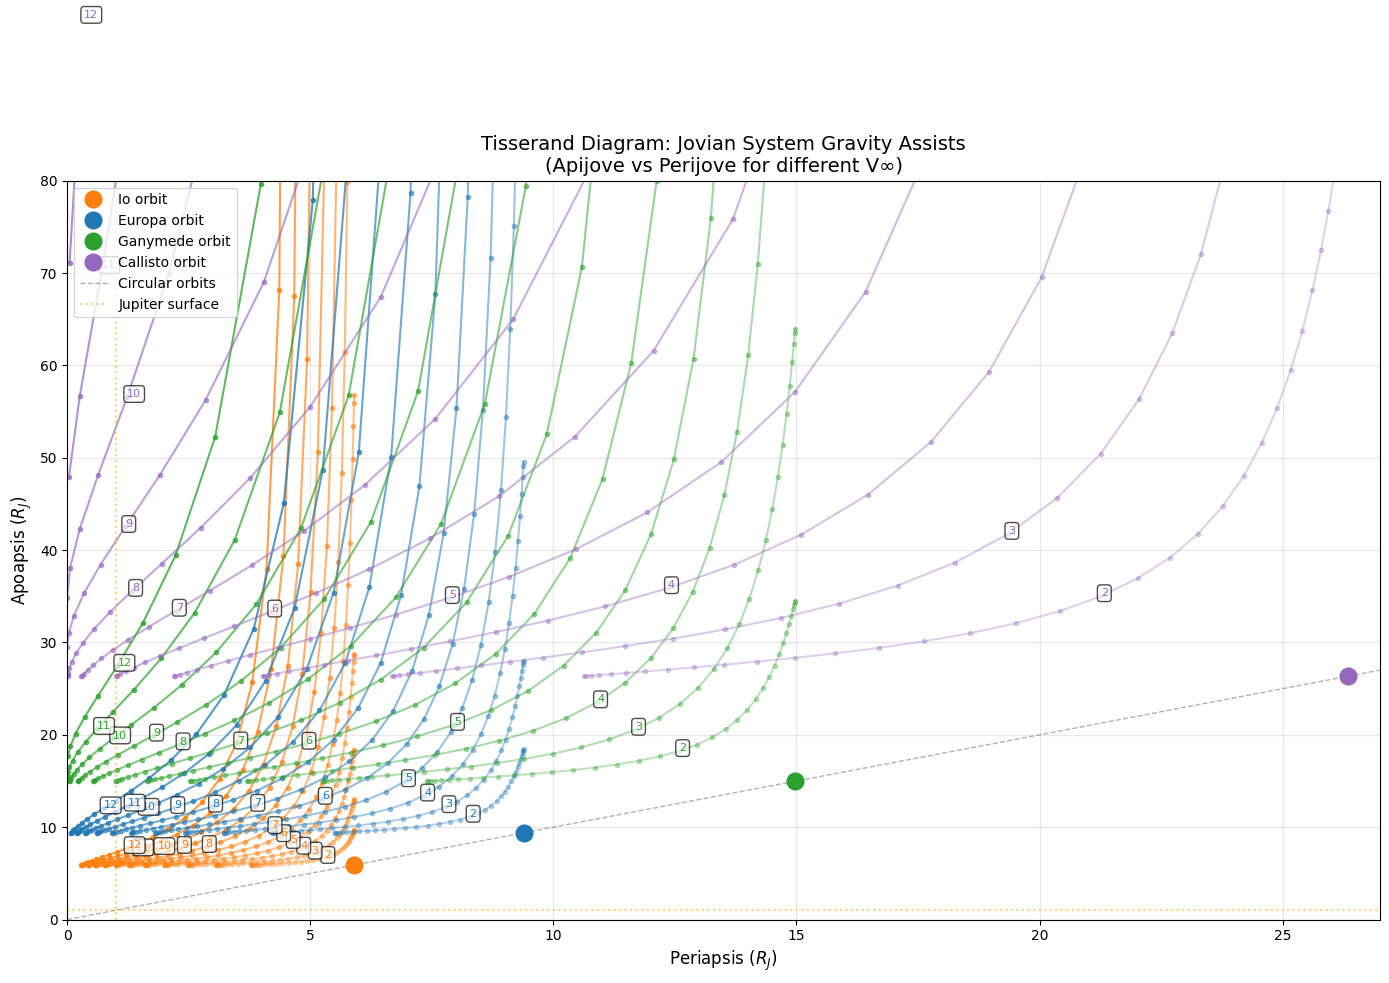

Tisserand diagram showing possible orbits after gravity assists
V∞ range: 2.0 km / s to 12.0 km / s
Angle step: 5°
Jupiter radius: 71492 km


In [9]:
## Plot Tisserand diagram - Apijove vs Perijove contours for each moon and V_infinity

fig, ax = plt.subplots(figsize=(14, 10))

# Convert Jupiter radius to km for scaling
R_J = Jupiter.R.to(u.km).value

# Plot contours for each moon
for i, body in enumerate(bodies):
    body_name = body.name
    color = moon_colors[body_name]
    
    # Get the moon's orbital radius for reference
    body_ephem = Ephem.from_horizons(match_astro_query_num(body), epochs=epoch, attractor=Jupiter, plane=Planes.EARTH_ECLIPTIC)
    body_orb = Orbit.from_ephem(Jupiter, body_ephem, start_date)
    moon_radius_RJ = body_orb.a.to(u.km).value / R_J  # Convert to R_J
    
    # Plot a point for the moon's orbit (circular, so r_p = r_a)
    ax.plot(moon_radius_RJ, moon_radius_RJ, 'o', color=color, markersize=12, 
            label=f'{body_name} orbit', zorder=10)
    
    # Plot contours for each V_infinity
    for j, v_infty in enumerate(v_inftys):
        # Extract periapsis and apoapsis for this V_infinity and all angles
        periapses = orb_points[i, j, :, 0] / R_J  # Convert to R_J
        apoapses = orb_points[i, j, :, 1] / R_J   # Convert to R_J
        
        # Filter out invalid points (zeros or NaNs)
        valid_mask = (periapses > 0) & (apoapses > 0) & np.isfinite(periapses) & np.isfinite(apoapses)
        periapses_valid = periapses[valid_mask]
        apoapses_valid = apoapses[valid_mask]
        
        if len(periapses_valid) > 0:
            # Plot the contour for this V_infinity with markers at each angle
            alpha = 0.3 + 0.5 * (j / len(v_inftys))  # Vary transparency with V_infinity
            ax.plot(periapses_valid, apoapses_valid, 'o-', color=color, 
                   alpha=alpha, linewidth=1.5, markersize=3)
            
            # Label the first and last V_infinity contours
            # if j == 0 or j == len(v_inftys) - 1:
            mid_idx = len(periapses_valid) // 2
            ax.text(periapses_valid[mid_idx], apoapses_valid[mid_idx], 
                    f'{v_infty.value:.0f}', fontsize=8, color=color,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Add diagonal line (circular orbits: r_p = r_a)
max_r = np.max(orb_points[orb_points > 0]) / R_J
ax.plot([0, max_r], [0, max_r], 'k--', alpha=0.3, linewidth=1, label='Circular orbits')

# Add Jupiter radius line
ax.axvline(1.0, color='orange', linestyle=':', alpha=0.5, label='Jupiter surface')
ax.axhline(1.0, color='orange', linestyle=':', alpha=0.5)

# Formatting
ax.set_xlabel('Periapsis ($R_J$)', fontsize=12)
ax.set_ylabel('Apoapsis ($R_J$)', fontsize=12)
ax.set_title('Tisserand Diagram: Jovian System Gravity Assists\n(Apijove vs Perijove for different V∞)', fontsize=14)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(left=0, right=27)
ax.set_ylim(bottom=0, top=80)

plt.tight_layout()
plt.show()

print("Tisserand diagram showing possible orbits after gravity assists")
print(f"V∞ range: {v_inftys[0]} to {v_inftys[-1]}")
print(f"Angle step: {anglestep}°")
print(f"Jupiter radius: {R_J:.0f} km")